# Computer Vision Libraries in PyTorch
* `torchvision`: Base domain library for PyTorch Computer Vision
* `torchvision.datasets`: Get datasets and data loading functions for computer vision
* `torchvision.models`: Get pretrained computer vision models
* `torchvision.transform`: Functions for transforming images

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Needed to see our model in a tabular format
try:
    from torchinfo import summary
except:
    ! pip install torchinfo
    from torchinfo import summary

In [ ]:
# Timing how long our model takes
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device:torch.device = None):
    total_time = end - start
    print(f"Total time on {device} is {total_time: .3f} seconds")

In [ ]:
train_data = datasets.MNIST(
    root = 'data', # Where to download the data to
    train= True,
    download= True,
    transform= transforms.ToTensor(),
    target_transform= None
)

100%|██████████| 9912422/9912422 [00:00<00:00, 90177513.26it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119817699.13it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25243888.40it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15203933.57it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None
)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
# Getting the accuracy function from torchmetrics
try:
    from torchmetrics import accuracy_fn
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy
accuracy_fn = Accuracy(task= 'multiclass', num_classes= len(class_names)).to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.3 MB/s eta 0:00:00


## Visualizing the dataset

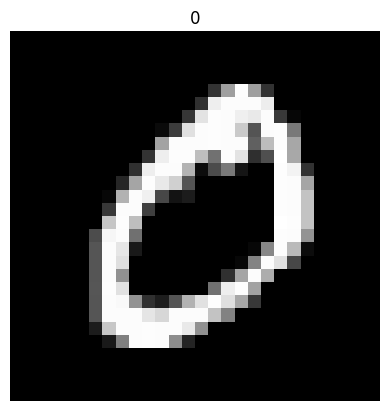

In [ ]:
image, label = train_data[1]
plt.imshow(image.squeeze(), cmap= 'gray')
plt.title(label)
plt.axis(False);

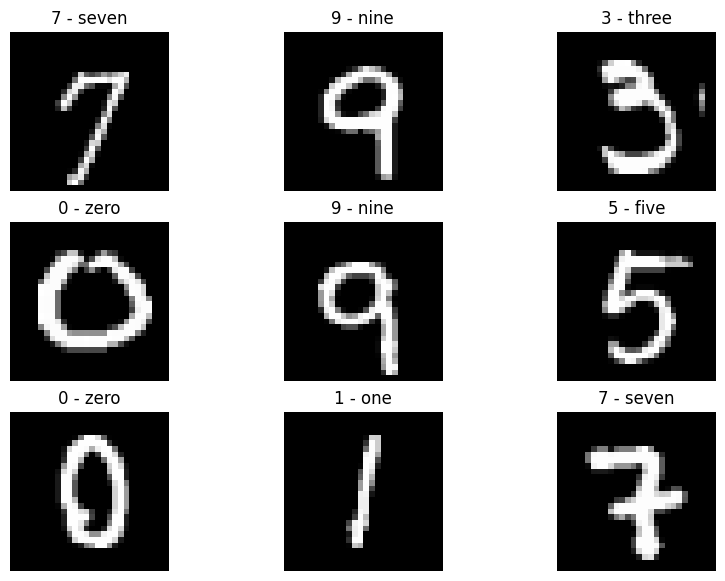

In [ ]:
## Plotting random images from our dataset
torch.manual_seed(8)
fig = plt.figure(figsize= (10, 7))
rows = 3
cols = 3
for i in range(1, rows * cols + 1):
    rand_idx = torch.randint(0, len(train_data), size= [1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap= 'gray')
    plt.title(class_names[label])
    plt.axis(False);


## Preparing the DataLoader

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
10000 / 32

312.5

In [ ]:
BATCH_SIZE = 32

train_data_loader = DataLoader(train_data, BATCH_SIZE, shuffle= True)
test_data_loader = DataLoader(test_data, BATCH_SIZE, shuffle= False)

print(f"We have {len(train_data_loader)} training batches")
print(f"We have {len(test_data_loader)} test batches")

We have 1875 training batches
We have 313 test batches


In [ ]:
train_images_batch, train_labels_batch = next(iter(train_data_loader))
print(f"Sample image size: {train_images_batch.shape}")

Sample image size: torch.Size([32, 1, 28, 28])


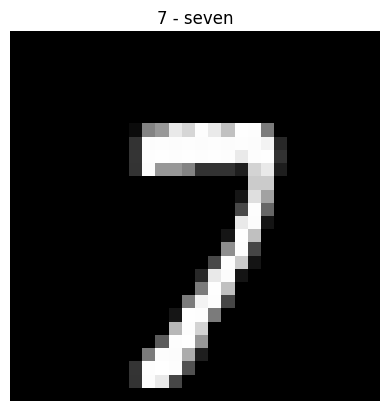

In [ ]:
torch.manual_seed(17)
rand_idx = torch.randint(0, len(train_images_batch), size= [1]).item()
img, label = train_images_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap= 'gray')
plt.title(class_names[label])
plt.axis(False);

## Defining the train step
* Includes a function that we can call everytime we wish to train the model
* Takes in the model, loss function, optimizers, dataloaders and accuracy function

In [ ]:
def train_step(model, loss_fn, optimizer, train_data_loader, device= device, accuracy_fn= accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(train_data_loader):
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X) # Logits
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim= 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_data_loader)
    avg_train_acc = train_acc / len(train_data_loader)
    print(f"Train loss: {avg_train_loss: .4f}")
    print(f"Train acc: {avg_train_acc: .4f}")

## Defining test step
* Includes the testing function
* Takes in the model, loss function and dataloaders
* Outputs the model's loss and accuracy

In [ ]:
train_images_batch, train_labels_batch = next(iter(test_data_loader))
print(f"Sample image size: {train_images_batch.shape}")

Sample image size: torch.Size([32, 1, 28, 28])


In [ ]:
def test_step(model, loss_fn, data_loader, device= device, accuracy_fn= accuracy_fn):
    '''Performs a testing loop on the model'''
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            # Forward Pass
            y_test_logits = model(X_test)
            # print(f"Test logits shape: {y_test_logits.shape}")
            # print(f"Test shape: {y_test.shape}")

            # Calculate the loss
            test_loss += loss_fn(y_test_logits, y_test)
            test_acc += accuracy_fn(y_test, y_test_logits.argmax(dim= 1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss: .4f}")
        print(f"Test accuracy: {test_acc: .4f}\n")

## Creating the model (using the functionized way)
* Making a CNN block
    * Convolutional layer
    * MaxPooling
    * ReLU
* Using the above block twice in the main model class

In [ ]:
def CNN_block(input_shape, output_shape, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels= input_shape, out_channels= output_shape, kernel_size= kernel_size, stride= stride, padding= padding),
        nn.MaxPool2d(kernel_size= 2),
        nn.ReLU(inplace= True)
    )

In [ ]:
class CNN_model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.main = nn.Sequential(
            CNN_block(input_shape, hidden_units, 5, 2, 1),
            CNN_block(hidden_units, hidden_units // 4, 3, 1, 1),
        )

        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units // 4 * 9, out_features= output_shape)
        )

    def forward(self, x):
        return self.classifier_layer(self.main(x))

In [ ]:
model_0 = CNN_model(1, 128, len(class_names))
summary(model_0, (BATCH_SIZE, 1, 28, 28), col_names= ["input_size", "output_size", "num_params", "kernel_size", "trainable"], col_width= 20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Kernel Shape         Trainable
CNN_model                                [32, 1, 28, 28]      [32, 10]             --                   --                   True
├─Sequential: 1-1                        [32, 1, 28, 28]      [32, 32, 3, 3]       --                   --                   True
│    └─Sequential: 2-1                   [32, 1, 28, 28]      [32, 128, 6, 6]      --                   --                   True
│    │    └─Conv2d: 3-1                  [32, 1, 28, 28]      [32, 128, 13, 13]    3,328                [5, 5]               True
│    │    └─MaxPool2d: 3-2               [32, 128, 13, 13]    [32, 128, 6, 6]      --                   2                    --
│    │    └─ReLU: 3-3                    [32, 128, 6, 6]      [32, 128, 6, 6]      --                   --                   --
│    └─Sequential: 2-2                   [32, 128, 6, 6]      [32, 32, 3, 3]       --    

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params= model_0.parameters(), lr= 0.0002)

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(17)
epochs = 7
model_start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"For epoch: {epoch + 1}\n")
    train_step(model_0, loss_fn, optimizer, train_data_loader)
    test_step(model_0, loss_fn, test_data_loader)
model_end_time = timer()
print_train_time(model_start_time, model_end_time, device)

  0%|          | 0/7 [00:00<?, ?it/s]

For epoch: 1

Train loss:  0.3767
Train acc:  0.9014
Test loss:  0.1100
Test accuracy:  0.9679

For epoch: 2

Train loss:  0.1027
Train acc:  0.9699
Test loss:  0.0760
Test accuracy:  0.9744

For epoch: 3

Train loss:  0.0748
Train acc:  0.9779
Test loss:  0.0564
Test accuracy:  0.9826

For epoch: 4

Train loss:  0.0605
Train acc:  0.9819
Test loss:  0.0484
Test accuracy:  0.9864

For epoch: 5

Train loss:  0.0515
Train acc:  0.9849
Test loss:  0.0460
Test accuracy:  0.9842

For epoch: 6

Train loss:  0.0460
Train acc:  0.9855
Test loss:  0.0445
Test accuracy:  0.9866

For epoch: 7

Train loss:  0.0406
Train acc:  0.9872
Test loss:  0.0373
Test accuracy:  0.9877

Total time on cuda is  92.600 seconds


## Re-Creating Lenet-5 architecture

In [ ]:
def LeNet_block(input_shape, output_shape, kernel_size, stride, padding= 0):
    return nn.Sequential(
        nn.Conv2d(in_channels= input_shape, out_channels= output_shape,
                  kernel_size= kernel_size, stride= stride, padding= padding),
        nn.AvgPool2d(kernel_size= 2),
        nn.Tanh()
    )

In [ ]:
class LeNet(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()

        self.main = nn.Sequential(
            LeNet_block(input_shape, output_shape= 8, kernel_size= 3, stride= 1), # img_size: 26x26x8 -> 13x13x8
            LeNet_block(8, output_shape= 16 ,kernel_size= 3, stride= 1), # img_size: 11x11x16 -> 5x5x16
            nn.Conv2d(in_channels= 16, out_channels= 120, kernel_size= 5, stride= 1) # img_size: 1x1x120
        )

        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 120, out_features= 84),
            nn.Tanh(),
            nn.Linear(in_features= 84, out_features= output_shape),
        )

    def forward(self, x):
        return self.classifier_layer(self.main(x))

In [ ]:
model_1 = LeNet(1, len(class_names)).to(device)
summary(model_1, (BATCH_SIZE, 1, 28, 28), col_names= ["input_size", "output_size", "num_params", "kernel_size", "trainable"], col_width= 20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Kernel Shape         Trainable
LeNet                                    [32, 1, 28, 28]      [32, 10]             --                   --                   True
├─Sequential: 1-1                        [32, 1, 28, 28]      [32, 120, 1, 1]      --                   --                   True
│    └─Sequential: 2-1                   [32, 1, 28, 28]      [32, 8, 13, 13]      --                   --                   True
│    │    └─Conv2d: 3-1                  [32, 1, 28, 28]      [32, 8, 26, 26]      80                   [3, 3]               True
│    │    └─AvgPool2d: 3-2               [32, 8, 26, 26]      [32, 8, 13, 13]      --                   2                    --
│    │    └─Tanh: 3-3                    [32, 8, 13, 13]      [32, 8, 13, 13]      --                   --                   --
│    └─Sequential: 2-2                   [32, 8, 13, 13]      [32, 16, 5, 5]       --    

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params= model_1.parameters(), lr= 0.0004)

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(17)
epochs = 7
model_start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"For epoch: {epoch + 1}\n")
    train_step(model_1, loss_fn, optimizer, train_data_loader)
    test_step(model_1, loss_fn, test_data_loader)
model_end_time = timer()
print_train_time(model_start_time, model_end_time, device)

  0%|          | 0/7 [00:00<?, ?it/s]

For epoch: 1

Train loss:  0.4151
Train acc:  0.8794
Test loss:  0.2280
Test accuracy:  0.9328

For epoch: 2

Train loss:  0.2012
Train acc:  0.9399
Test loss:  0.1716
Test accuracy:  0.9481

For epoch: 3

Train loss:  0.1507
Train acc:  0.9552
Test loss:  0.1277
Test accuracy:  0.9612

For epoch: 4

Train loss:  0.1193
Train acc:  0.9645
Test loss:  0.1021
Test accuracy:  0.9705

For epoch: 5

Train loss:  0.1001
Train acc:  0.9697
Test loss:  0.0887
Test accuracy:  0.9734

For epoch: 6

Train loss:  0.0870
Train acc:  0.9740
Test loss:  0.0828
Test accuracy:  0.9748

For epoch: 7

Train loss:  0.0766
Train acc:  0.9765
Test loss:  0.0844
Test accuracy:  0.9729

Total time on cuda is  105.716 seconds


## Tweaking LeNet architecture

In [ ]:
class LeNet(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()

        self.main = nn.Sequential(
            LeNet_block(input_shape, output_shape= 16, kernel_size= 3, stride= 1, padding= 1),
            LeNet_block(16, output_shape= 32 ,kernel_size= 3, stride= 1, padding= 1),
            nn.Conv2d(in_channels= 32, out_channels= 16, kernel_size= 3, stride= 1, padding= 1)
        )

        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 784, out_features= output_shape)
        )

    def forward(self, x):
        return self.classifier_layer(self.main(x))

In [ ]:
model_2 = LeNet(1, len(class_names)).to(device)
summary(model_2, (BATCH_SIZE, 1, 28, 28), col_names= ["input_size", "output_size", "num_params", "kernel_size", "trainable"], col_width= 20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Kernel Shape         Trainable
LeNet                                    [32, 1, 28, 28]      [32, 10]             --                   --                   True
├─Sequential: 1-1                        [32, 1, 28, 28]      [32, 16, 7, 7]       --                   --                   True
│    └─Sequential: 2-1                   [32, 1, 28, 28]      [32, 16, 14, 14]     --                   --                   True
│    │    └─Conv2d: 3-1                  [32, 1, 28, 28]      [32, 16, 28, 28]     160                  [3, 3]               True
│    │    └─AvgPool2d: 3-2               [32, 16, 28, 28]     [32, 16, 14, 14]     --                   2                    --
│    │    └─Tanh: 3-3                    [32, 16, 14, 14]     [32, 16, 14, 14]     --                   --                   --
│    └─Sequential: 2-2                   [32, 16, 14, 14]     [32, 32, 7, 7]       --    

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params= model_2.parameters(), lr= 0.0002)
torch.manual_seed(17)
epochs = 8


model_start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"For epoch: {epoch + 1}\n")
    train_step(model_2, loss_fn, optimizer, train_data_loader)
    test_step(model_2, loss_fn, test_data_loader)
model_end_time = timer()
print_train_time(model_start_time, model_end_time, device)

  0%|          | 0/8 [00:00<?, ?it/s]

For epoch: 1

Train loss:  0.4875
Train acc:  0.8567
Test loss:  0.3118
Test accuracy:  0.9092

For epoch: 2

Train loss:  0.3062
Train acc:  0.9105
Test loss:  0.2660
Test accuracy:  0.9242

For epoch: 3

Train loss:  0.2695
Train acc:  0.9206
Test loss:  0.2360
Test accuracy:  0.9321

For epoch: 4

Train loss:  0.2318
Train acc:  0.9315
Test loss:  0.1978
Test accuracy:  0.9418

For epoch: 5

Train loss:  0.1914
Train acc:  0.9432
Test loss:  0.1614
Test accuracy:  0.9510

For epoch: 6

Train loss:  0.1554
Train acc:  0.9534
Test loss:  0.1424
Test accuracy:  0.9569

For epoch: 7

Train loss:  0.1299
Train acc:  0.9607
Test loss:  0.1069
Test accuracy:  0.9672

For epoch: 8

Train loss:  0.1133
Train acc:  0.9660
Test loss:  0.0981
Test accuracy:  0.9686

Total time on cuda is  105.739 seconds
